# Project3: Finetuning an Image Classification Model with a custom dataset in AWS SageMaker: script mode (custom training), hyperparameter tuning, model profiling and debugger, and others good ML engineering practices.


Here the Resnet18, image classification model, is finetuned using an external dataset of dog images containing 133 classes each one corresponding to a dog breed. The model is submited and deployed using Sagemaker Python SDK. Some lines of code are in boto3 and/or AWS CLI for illustration (or simplicity).

The Sagemaker ML framework used is PyTorch {`sagemaker.pytorch`}. The model definition and the training and inference code are passed in to PyTorch container via Sagemaker script mode. Script mode allows for custom training and inference code while still utilizing common ML framework containers mantained by AWS.

SageMaker APIs used include: Amazon Sagemaker Debugger {`sagemaker.debugger`} to profile and debugg the training job in real time; and the Sagemaker trainning APIs HyperparameterTuner {`sagemaker.tuner.HyperparameterTuner`} and Parameters to perform hyperparameter tuning.

This notebook represents the *submission script* and contains the code to download and preprocess the data and setups to Sagemaker APIs to submit and evaluate the training job.

The *training scrips* (`hpo.py`, `train_model.py`) contain the model definition and the training and validation code. These scripts specify hyperparameters and environmental variables through parser arguments while the *submission script* reads hyperparameters and environmental variables through command line arguments (i.e. at runtime).

More specifically, the `hpo.py` script is used when performing hyperparameter tuning and contains the code to train the model and save it to S3 (`torch.save(model.state_dict(), "model_dir/model.pth")`); and the `train_model.py` contains code to perform model profiling and debugging.

The *inference script* (`inference.py`) contains the code to the Sagemaker Model Server functions for deserializing the trained model and load it for inference (`model.load_state_dict(torch.load(model_dir))`) and for translating an endpoint request to an inference call to the model. Respectivelly, model loading function (`model_fn`) and model serving functions (`input_fn` and `prediction_fn`).


## <a name="0">Notebook content:</a>
1. <a href="#1">Notebook set-up</a>
2. <a href="#2">Dataset</a><br>
    2.1. <a href="#2.1">S3 configuration</a><br>
    2.2. <a href="#2.2">ETL</a><br>
    2.3. <a href="#2.3">Manifest files</a><br>
    2.4 <a href="#2.4">Define Data Channels</a>
3. <a href="#3">Hyperparameter Tuning</a><br>
    3.1. <a href="#3.1">Define training Hyperparameters and Pytorch estimator</a><br>
    3.2. <a href="#3.2">Define objective metric and hyperparameters ranges for HyperparameterTuner</a>
4. <a href="#4">Monitoring and analysis of model training: Sagemaker Profiler and Debugger</a><br>
    4.1. <a href="#4.1">Set-up debugging and profiling configuration (rules and hooks)</a><br>
    4.2. <a href="#4.2">Create and finetune a new model</a><br>
    4.3. <a href="#4.3">Plot debugger tensors</a><br>
    4.4. <a href="#4.4">Display profiler data (timeline chart and profiler report)</a>
5. <a href="#5">Model Deployment</a><br>
    5.1. <a href="#5.1">Create Model</a><br>
    5.2. <a href="#5.2">Create Endpoint</a><br>
    5.3. <a href="#5.3">Perform Inference</a><br>
    5.4. <a href="#5.4">Clean up</a>




**Instructor notes:** This notebook lists all the steps that you need to complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts (`train_model.py` and `hpo.py`) included with the starter code.

The TODOs in this notebook are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

## 1. <a name="1">Notebook set-up</a>
(<a href="#0">Go to top</a>)

In [1]:
# TODO: Install any packages that might be needed
# For instance, smdebug package
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 47.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.19
    Uninstalling botocore-1.24.19:
      Successfully uninstalled botocore-1.24.19
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.22.97 requires botocore==1.24.42, but you have botocore 1.24.46 which is incompatible.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.24.46 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
# Import any packages that might be needed
# For instance Boto3 and Sagemaker and PyTorch ML framework 
import boto3
import sagemaker

from sagemaker import get_execution_role

from sagemaker.pytorch import PyTorch

from sagemaker.tuner import(
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

from sagemaker.debugger import(
    Rule,
    ProfilerRule,
    rule_configs,
    DebuggerHookConfig,
    ProfilerConfig,
    FrameworkProfile,
    CollectionConfig
)

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import io
import pickle
import requests

## 2. <a name="2">Dataset</a>
(<a href="#0">Go to top</a>)

The dataset used is composed of 7649 images of dogs. There are 6680 images in the training dataset, 836 images in the test dataset and 835 in validation dataset. It contains 133 classes of dog breeds, such as Airedale_terrier, Beagle, Bulldog, Dalmatian, etc.
The dataset was provided by @udacity/active-public-content and can be downloaded from the link https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

### 2.1. <a name="2.1">S3 configuration</a>
(<a href="#0">Go to top</a>)

In [3]:
# grab sagemaker session and define s3 bucket name or use sagemaker.Session().default_bucket
# then, define file path prefix to send data to S3 bucket

sm_session = sagemaker.Session()
bucket = "project3-260722" ##sm_session.default_bucket()

prefix = "data-projeto3"

print(f"Bucket: {bucket}")
print(f"S3 path: {bucket}/{prefix}")

input_data = f"S3 path: {bucket}/{prefix}"

Bucket: project3-260722
S3 path: project3-260722/data-projeto3


### 2.2. <a name="2.2">ETL</a>
(<a href="#0">Go to top</a>)

In [4]:
%%time
# Fetching data from AWS S3

"""
# download and unzip data using aws CLI
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
"""

## OR

# download data using {requests}

url = "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip"

# request data from url
with open('./dogImages.zip', 'wb') as f:
    f.write(requests.get(url).content)

# extract / unzip data
import shutil
shutil.unpack_archive('./dogImages.zip', './')


CPU times: user 7.63 s, sys: 4.65 s, total: 12.3 s
Wall time: 49.4 s


In [5]:
%%time
# check data integrity

## function to check for image integrity and remove invalid files
def check_data_integrity(root):
    f_count=0
    invalid_files = []

    for (r, d, f) in os.walk(root, topdown=True):
        for file in f:
            path = os.path.join(r, file)
            f_img = Image.open(path)
            try:
                f_img.load()
            except Exception as e:
                invalid_files.append(file)
                os.remove(path)
    print(f"Number of Invalid Files: {len(invalid_files)}")

## call check_data_integrity
check_data_integrity("./dogImages/train")
check_data_integrity("./dogImages/test")
check_data_integrity("./dogImages/valid")


Number of Invalid Files: 1
Number of Invalid Files: 0
Number of Invalid Files: 0
CPU times: user 27.5 s, sys: 630 ms, total: 28.1 s
Wall time: 28.6 s


In [6]:
%%time
# upload all the data to S3
## upload local 'data' directories (train, test, and valid) to S3 with sm_session.upload_data()
## return S3 URI
input_data = sm_session.upload_data(path='./dogImages', bucket=bucket, key_prefix=prefix)
print('path to data in S3: {}'.format(input_data))

path to data in S3: s3://project3-260722/data-projeto3
CPU times: user 45.4 s, sys: 5.35 s, total: 50.8 s
Wall time: 10min 47s


In [ ]:
# -----------------------------------------------------------------------------------------

In [ ]:
### Likewise, the data can be uploaded to s3 using aws CLI (using the code in the cell bellow) instead

In [ ]:
%%time
# Upload data to S3 bucket using aws CLI
aws s3 cp ./dogImages/train s3://{bucket}/{prefix}/train --recursive
aws s3 cp ./dogImages/test s3://{bucket}/{prefix}/test --recursive
aws s3 cp ./dogImages/valid s3://{bucket}/{prefix}/valid --recursive

In [ ]:
# -----------------------------------------------------------------------------------------

In [7]:
# optional: delete local copy of .zip data file

if os.path.exists('./dogImages.zip'):
    os.remove('./dogImages.zip')
else:
    print("Files does not exist")

### 2.3. <a name="2.3">Manifest files</a>
(<a href="#0">Go to top</a>)

["A .lst file is a tab-separated file with three columns that contains a list of image files. The first column specifies the image index, the second column specifies the class label index for the image, and the third column specifies the relative path of the image file. The image index in the first column must be unique across all of the images. The set of class label indices are numbered successively and the numbering should start with 0. For example, 0 for the cat class, 1 for the dog class, and so on for additional classes."](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) (Sagemaker Developer Guide: Image Classification Algorithm. Train with Image Format)

In [4]:
# create a dictionary of classes (133 classes) that can be used later when selecting image for quering the model
  
# get the list of all files and directories in ./data/dogImages/train directory
path = "./dogImages/train"
dir_list = os.listdir(path)

dict_cls = {}
for term in dir_list:
    dict_cls[int(term.split('.')[0])-1] = term.split('.')[1]

print(f"Number of Classes: {len(dir_list)}")


Number of Classes: 133


In [5]:
dict_cls

{125: 'Saint_bernard',
 124: 'Portuguese_water_dog',
 1: 'Afghan_hound',
 53: 'Collie',
 24: 'Black_and_tan_coonhound',
 39: 'Bulldog',
 67: 'Flat-coated_retriever',
 95: 'Labrador_retriever',
 51: 'Clumber_spaniel',
 106: 'Norfolk_terrier',
 59: 'Dogue_de_bordeaux',
 10: 'Australian_cattle_dog',
 122: 'Pomeranian',
 109: 'Norwegian_lundehund',
 116: 'Pekingese',
 43: 'Cane_corso',
 45: 'Cavalier_king_charles_spaniel',
 34: 'Boykin_spaniel',
 126: 'Silky_terrier',
 78: 'Great_pyrenees',
 31: 'Boston_terrier',
 92: 'Kerry_blue_terrier',
 123: 'Poodle',
 104: 'Neapolitan_mastiff',
 72: 'German_wirehaired_pointer',
 41: 'Cairn_terrier',
 111: 'Nova_scotia_duck_tolling_retriever',
 129: 'Welsh_springer_spaniel',
 85: 'Irish_setter',
 89: 'Italian_greyhound',
 64: 'Entlebucher_mountain_dog',
 35: 'Briard',
 18: 'Bedlington_terrier',
 17: 'Beauceron',
 96: 'Lakeland_terrier',
 49: 'Chinese_shar-pei',
 19: 'Belgian_malinois',
 121: 'Pointer',
 52: 'Cocker_spaniel',
 113: 'Otterhound',
 56: 'D

In [10]:
# Build a list file (.lst file) with the labels for each set of data
# "labels" are classes numbers from from 0 to 132 (133 classes)
## Note, labels start from zero (0) to meet Sagemaker requirements
# "s3_path" are dir/file_name
# "row" are the row indexes

def create_manifest_file(dir, prefix):

    path = os.path.join(dir, prefix)
    dir_list = os.listdir(path)
    dir_list.sort()

    filepath_list = []
    label_list = []
    for label in dir_list:
        directory = os.path.join(path, label)
        for (r, d, f) in os.walk(directory, topdown=True):
            for file in f:
                filepath_list.append(os.path.join(label, file))
                label_list.append(int(label.split('.')[0])-1) ## [0 to 132]

    pd.DataFrame({
        "row":range(len(filepath_list)),
        "labels":label_list,
        "s3_path":filepath_list
    }).to_csv(path_or_buf=os.path.join(dir, f"{prefix}.lst"), sep='\t', header=False, index=False)
    
    print(f"{prefix}.lst created!")

In [11]:
dir = "./dogImages/"

create_manifest_file(dir, 'train')
create_manifest_file(dir, 'test')
create_manifest_file(dir, 'valid')

train.lst created!
test.lst created!
valid.lst created!


In [12]:
%%time
# upload list files to s3

train_lst_path = sm_session.upload_data(path='./dogImages/train.lst', bucket=bucket, key_prefix=prefix)
print('train.lst uploaded to the s3 path:\n {}'.format(train_lst_path))

test_lst_path = sm_session.upload_data(path='./dogImages/test.lst', bucket=bucket, key_prefix=prefix)
print('test.lst uploaded to the s3 path:\n {}'.format(test_lst_path))

valid_lst_path = sm_session.upload_data(path='./dogImages/valid.lst', bucket=bucket, key_prefix=prefix)
print('valid.lst uploaded to the s3 path:\n {}'.format(valid_lst_path))

train.lst uploaded to the s3 path:
 s3://project3-260722/data-projeto3/train.lst
test.lst uploaded to the s3 path:
 s3://project3-260722/data-projeto3/test.lst
valid.lst uploaded to the s3 path:
 s3://project3-260722/data-projeto3/valid.lst
CPU times: user 57.3 ms, sys: 4.14 ms, total: 61.4 ms
Wall time: 419 ms


In [ ]:
# -----------------------------------------------------------------------------------------

In [ ]:
### run the cell bellow only if you need the file paths to .lst files in s3
### (i.e., only if you didn't run the cell above) and you need to re-define the paths to metadata

In [5]:
input_data = f"s3://{bucket}/data-projeto3"

train_lst_path = f"s3://{bucket}/data-projeto3/train.lst"

test_lst_path = f"s3://{bucket}/data-projeto3/test.lst"

valid_lst_path = f"s3://{bucket}/data-projeto3/valid.lst"

In [6]:
print('Bucket:\n {}'.format(bucket))

print('s3 path to data:\n {}'.format(input_data))

print('s3 path to train.lst:\n {}'.format(train_lst_path))

print('s3 path to test.lst:\n {}'.format(test_lst_path))

print('s3 path to valid.lst:\n {}'.format(valid_lst_path))

Bucket:
 project3-260722
s3 path to data:
 s3://project3-260722/data-projeto3
s3 path to train.lst:
 s3://project3-260722/data-projeto3/train.lst
s3 path to test.lst:
 s3://project3-260722/data-projeto3/test.lst
s3 path to valid.lst:
 s3://project3-260722/data-projeto3/valid.lst


In [ ]:
# -----------------------------------------------------------------------------------------

### 2.4 <a name="2.4">Define Data Channels</a>
(<a href="#0">Go to top</a>)


In [7]:
# model data channels

model_inputs = {
    "train": sagemaker.inputs.TrainingInput(
        s3_data=f"{input_data}/train",
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "test": sagemaker.inputs.TrainingInput(
        s3_data=f"{input_data}/test",
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "valid": sagemaker.inputs.TrainingInput(
        s3_data=f"{input_data}/valid",
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "train_lst": sagemaker.inputs.TrainingInput(
        s3_data=train_lst_path,
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "test_lst": sagemaker.inputs.TrainingInput(
        s3_data=test_lst_path,
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "valid_lst": sagemaker.inputs.TrainingInput(
        s3_data=valid_lst_path,
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    )
}


## 3. <a name="3">Hyperparameter Tuning</a>
(<a href="#0">Go to top</a>)

This is the part where the pretrained model is finetuned with hyperparameter tuning. 

**TODO:** Remember that you have to tune a minimum of two hyperparameters.

**Note:** use the `hpo.py` script to perform hyperparameter tuning.

### 3.1. <a name="3.1">Define training Hyperparameters and Pytorch estimator</a>
(<a href="#0">Go to top</a>)

**Recommeded reading:**

1. AWS Sagemaker Read the Docs. Use PyTorch with the SageMaker Python SDK: [Deploy PyTorch Models](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html)

2. Amazon Sagemaker developer guide: [Image Classification Instances](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html#IC-instances)

3. AWS Sagemaker: [SageMaker instance pricing](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html)

In [9]:
# define hyperparameters
# Note: hyperparameters are specified and read via command line arguments 
hyperparameters = {
    'epochs':'8',
    'batch_size':'40',
    'test_batch_size':'209',
    'lr':'0.005',
}

# initialize estimators
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="sagemaker-project3", #prefix for training job name
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.4xlarge", #"ml.p3.2xlarge", #"ml.p2.xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
)

In [10]:
%%time
### fit model to check algorithm :::--->

estimator.fit(inputs=model_inputs, logs=True)

2022-07-29 10:12:43 Starting - Starting the training job...
2022-07-29 10:13:09 Starting - Preparing the instances for trainingProfilerReport-1659089563: InProgress
.........
2022-07-29 10:14:37 Downloading - Downloading input data............
2022-07-29 10:16:38 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-07-29 10:16:37,036 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-29 10:16:37,038 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-29 10:16:37,046 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-07-29 10:16:37,053 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-07-29 10:16:37,488 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-29 10:

Train Epoch: 1, Average Loss: 0.36632388693644874
Train Epoch: 2, Average Loss: 0.3822123164419536
Train Epoch: 3, Average Loss: 0.3766931387314023
Train Epoch: 4, Average Loss: 0.3702436462992911
Train Epoch: 5, Average Loss: 0.37161418923647715
Train Epoch: 6, Average Loss: 0.3671429475315104
Train Epoch: 7, Average Loss: 0.3628359112951602
Train Epoch: 8, Average Loss: 0.3544180742690156

2022-07-29 10:37:50 Uploading - Uploading generated training modelTest set: Average loss: 0.05799734991703307
Test Accuracy 6.818181818181818%
Saving the model!!!
Model saved to /opt/ml/model/model.pth
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
#015  0%|          | 0.00/44.7M [00:00<?, ?B/s]#015 64%|██████▍   | 28.5M/44.7M [00:00<00:00, 299MB/s]#015100%|██████████| 44.7M/44.7M [00:00<00:00, 301MB/s]
2022-07-29 10:37:43,547 sagemaker-training-toolkit INFO     Reporting training SUCCESS

2022-07-29 10:38:24 Comp

### 3.2. <a name="3.2">Define objective metric and hyperparameters ranges for HyperparameterTuner</a>
(<a href="#0">Go to top</a>)

["The SageMaker Python SDK allows you to specify a name and a regular expression for metrics you want to track for training. A regular expression (regex) matches what is in the training algorithm logs, like a search function."](https://sagemaker.readthedocs.io/en/stable/overview.html#training-metrics) (Sagemaker Read the Docs: Using the SageMaker Python SDK. Using Estimators. Training Metrics)

See also:
1. Sagemaker Developer Guide: [Define Metrics](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-define-metrics.html)

In [11]:
# define hyperparameters ranges
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.001, 0.01, scaling_type='Logarithmic'),
    'batch_size': CategoricalParameter([40, 60]),
}

# objective metric to be used (added to HyperparameterTuner bellow)
objective_metric_name = "average test loss"

# define whether the metric needs to be minimized or maximized
objective_type = "Minimize"

# tell sagemaker what to look for in the logs (define training metrics)
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


In [12]:
# create hyperparameter tuner object and pass in the estimator
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    objective_type=objective_type,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=6, # number of hyperparameter jobs
    max_parallel_jobs=1,
    base_tuning_job_name=prefix,
)

In [13]:
%%time
tuner.fit(inputs=model_inputs, logs=True)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [14]:
tuner_best_training_job = tuner.best_training_job()

print("Best training job: {}".format(tuner_best_training_job))

Best training job: data-projeto3-220729-1043-005-cb49fd26


In [15]:
# Grab the best estimators and the best HPs

#Get the best trained model
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator_hyperparameters = tuner.best_estimator().hyperparameters()

print("Best estimator: {} \nBest hyperparameters: {}".format(best_estimator, best_estimator_hyperparameters))


2022-07-29 13:05:24 Starting - Preparing the instances for training
2022-07-29 13:05:24 Downloading - Downloading input data
2022-07-29 13:05:24 Training - Training image download completed. Training in progress.
2022-07-29 13:05:24 Uploading - Uploading generated training model
2022-07-29 13:05:24 Completed - Resource retained for reuse

2022-07-29 13:05:24 Starting - Preparing the instances for training
2022-07-29 13:05:24 Downloading - Downloading input data
2022-07-29 13:05:24 Training - Training image download completed. Training in progress.
2022-07-29 13:05:24 Uploading - Uploading generated training model
2022-07-29 13:05:24 Completed - Resource retained for reuse
Best estimator: <sagemaker.pytorch.estimator.PyTorch object at 0x7f9c4fb7d490> 
Best hyperparameters: {'_tuning_objective_metric': '"average test loss"', 'batch_size': '"60"', 'epochs': '"8"', 'lr': '0.0016232470062641088', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemak

In [16]:
results = tuner.analytics()
results_df = results.dataframe()

results_df

,batch_size,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""60""",0.003493,data-projeto3-220729-1043-006-91b76d7a,Completed,0.033503,2022-07-29 13:09:55+00:00,2022-07-29 13:36:49+00:00,1614.0
1,"""60""",0.001623,data-projeto3-220729-1043-005-cb49fd26,Completed,0.020642,2022-07-29 12:40:48+00:00,2022-07-29 13:05:21+00:00,1473.0
2,"""60""",0.001750,data-projeto3-220729-1043-004-475b1795,Completed,0.021337,2022-07-29 12:11:51+00:00,2022-07-29 12:36:39+00:00,1488.0
3,"""40""",0.001166,data-projeto3-220729-1043-003-f549c019,Completed,0.022014,2022-07-29 11:42:38+00:00,2022-07-29 12:05:55+00:00,1397.0
4,"""40""",0.009077,data-projeto3-220729-1043-002-92f53bd7,Completed,0.098945,2022-07-29 11:13:46+00:00,2022-07-29 11:37:27+00:00,1421.0
5,"""40""",0.009409,data-projeto3-220729-1043-001-03dcd317,Completed,0.104603,2022-07-29 10:45:05+00:00,2022-07-29 11:08:07+00:00,1382.0


**Grab best training parameters**

In [17]:
epochs =  ''.join(i for i in best_estimator_hyperparameters['epochs'] if i.isalnum())
print(f"epochs: {epochs}")

epochs: 8


In [18]:
test_batch_size =  ''.join(i for i in best_estimator_hyperparameters['test_batch_size'] if i.isalnum())
print(f"Test batch_size: {test_batch_size}")

Test batch_size: 209


In [19]:
best_batch_size = ''.join(i for i in best_estimator_hyperparameters['batch_size'] if i.isalnum())
print(f"Best batch_size: {best_batch_size}")

Best batch_size: 60


In [24]:
best_lr = str(best_estimator_hyperparameters['lr'])
print(f"Best lr: {best_lr}")

Best lr: 0.0016232470062641088


In [ ]:
# -----------------------------------------------------------------------------------------

In [8]:
epochs = '8'
test_batch_size = '209'
best_batch_size = '60'
best_lr = '0.0016232470062641088'

In [ ]:
# -----------------------------------------------------------------------------------------

In [26]:
## another way of getting the best training job description

sagemaker_boto_client = boto3.Session().client(service_name="sagemaker")

best_training_job_summary = results.description()["BestTrainingJob"]

best_training_job_summary

{'TrainingJobName': 'data-projeto3-220729-1043-005-cb49fd26',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:538248431797:training-job/data-projeto3-220729-1043-005-cb49fd26',
 'CreationTime': datetime.datetime(2022, 7, 29, 12, 39, 23, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2022, 7, 29, 12, 40, 48, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2022, 7, 29, 13, 5, 21, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'batch_size': '"60"', 'lr': '0.0016232470062641088'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'average test loss',
  'Value': 0.020641518756747246},
 'ObjectiveStatus': 'Succeeded'}

## 4. <a name="4">Monitoring and analysis of model training: Sagemaker Profiler and Debugger</a>
(<a href="#0">Go to top</a>)

Create and finetune a new model using the best hyperparameters, found in the previous section (**Hyperparameter Tuning**).

**Note:** use the `train_model.py` script to perform model profiling and debugging.

**Support reading:**

1. Sagemaker Developer Guide: [Amazon SageMaker Debugger API Operations](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-apis.html)

2. Sagemaker Developer Guide: [Configure Debugger Using Amazon SageMaker Python SDK](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-configuration.html)

3. Sagemaker Read the Docs: [Sagemaker Debugger](https://sagemaker.readthedocs.io/en/stable/api/training/debugger.html#)

4. AWS Machine Learning Blog: [ML Explainability with Amazon SageMaker Debugger](https://aws.amazon.com/blogs/machine-learning/ml-explainability-with-amazon-sagemaker-debugger/)


### 4.1. <a name="4.1">Set-up debugging and profiling configuration (rules and hooks)</a>
(<a href="#0">Go to top</a>)

In [27]:
# grab default_bucket name
bucket = sm_session.default_bucket()  ##"sagemaker-us-east-1-project3"
print(f"Bucket:{bucket}")

Bucket:sagemaker-us-east-1-538248431797


In [28]:
# configure debugger and profiler rules
rules = [
    ## debugger
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ## profiler
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]


In [29]:
# define tensor collections for SageMaker Debugger
collection_configs = [
    CollectionConfig(
        name = 'all',
        parameters={
            "include_regex": ".*",
            "train.save_interval": "100",
            "eval.save_interval": "10"
        }
    )
    
]

# define debugger (hook) configuration
hook_config = DebuggerHookConfig(
    s3_output_path = f"s3://{bucket}/project3/debug-output",
    hook_parameters={
        "train.save_interval": "100",
        "eval.save_interval": "10"
    },
    collection_configs = collection_configs
)


In [ ]:
##-----------------------------------------------------------------------

In [ ]:
# OR, a short way, without defining collections, to define debugger config is bellow

In [28]:
hook_config = DebuggerHookConfig(
    s3_output_path=f"s3://{bucket}/project3/debug-output",
    hook_parameters={
        "train.save_interval":"100",
        "eval.save_interval":"10"
    }
)

In [ ]:
##-----------------------------------------------------------------------

In [30]:
# define the profiler configuration
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)

### 4.2. <a name="4.2">Create and finetune a new model</a>
(<a href="#0">Go to top</a>)

In [31]:
# Create and fit an estimator with hyperparameters of the best model found in the previous section
# pass debugging and profiling rules and hooks to the estimator

hyperparameters = {
    'epochs': epochs,
    'batch_size': best_batch_size,
    'test_batch_size': test_batch_size,
    'lr': best_lr,
}

best_estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="bestmodel-project3", #prefix for training job name
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.4xlarge", #"ml.p3.2xlarge", #"ml.p2.xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
    rules=rules,
)


In [32]:
%%time

best_estimator.fit(inputs=model_inputs, logs=True)

2022-07-29 13:46:35 Starting - Starting the training job...
2022-07-29 13:46:50 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-07-29 13:48:02 Downloading - Downloading input data...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-07-29 13:49:45,045 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-29 13:49:45,047 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-29 13:49:45,056 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-07-29 13:49:45,062 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-07-29 13:49:45,489 sagemaker-training-toolkit I


2022-07-29 13:50:03 Training - Training image download completed. Training in progress.[2022-07-29 13:50:04.051 algo-1:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-1/train-0-stepstart-1659102589740741.8_train-0-forwardpassend-1659102604051135.8/python_stats.
[2022-07-29 13:50:05.557 algo-1:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-1/train-0-forwardpassend-1659102604057004.5_train-1-stepstart-1659102605556708.0/python_stats.
[2022-07-29 13:50:08.280 algo-1:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-1/train-1-stepstart-1659102605560866.0_train-1-forwardpassend-1659102608280220.5/python_stats.
[2022-07-29 13:50:09.650 algo-1:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-1/train-1-forwardpassend-165910

In [33]:
# get a full description of the training job
job_name = best_estimator.latest_training_job.name
client = best_estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName = job_name)

print(f"Training job name: {job_name}")
print(f"Description: {description}")

Training job name: bestmodel-project3-2022-07-29-13-46-34-435
Description: {'TrainingJobName': 'bestmodel-project3-2022-07-29-13-46-34-435', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:538248431797:training-job/bestmodel-project3-2022-07-29-13-46-34-435', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-538248431797/bestmodel-project3-2022-07-29-13-46-34-435/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '"60"', 'epochs': '"8"', 'lr': '"0.0016232470062641088"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"bestmodel-project3-2022-07-29-13-46-34-435"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-538248431797/bestmodel-project3-2022-07-29-13-46-34-435/source/sourcedir.tar.gz"', 'test_batch_size': '"209"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws

### 4.3. <a name="4.3">Plot debugger tensors</a>
(<a href="#0">Go to top</a>)

**Support reading:**

1. GitHub: [Tensor Analysis Using Amazon SageMaker Debugger](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/mnist_tensor_analysis/mnist_tensor_analysis.ipynb)

2. Sagemaker Developer Guide: [Visualize SageMaker Debugger Output Tensors](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-enable-tensorboard-summaries.html)

3. Sagemaker Developer Guide: [Best Practices for Amazon SageMaker Debugger](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-best-practices.html#debugger-best-practices-monitor-metrics)

In [34]:
# retrieve s3 location of debugger tensors
tensors_path = best_estimator.latest_job_debugger_artifacts_path()
print("S3 path to debugger tensors: ", tensors_path)

S3 path to debugger tensors:  s3://sagemaker-us-east-1-538248431797/project3/debug-output/bestmodel-project3-2022-07-29-13-46-34-435/debug-output


In [35]:
# Create an smdebug Trial object to retrieve the saved tensors

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(tensors_path)

# Fetch tensor names and print their lengths
trial.tensor_names()

[2022-07-29 14:19:53.131 ip-172-16-98-10.ec2.internal:8076 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-07-29 14:19:53.301 ip-172-16-98-10.ec2.internal:8076 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-538248431797/project3/debug-output/bestmodel-project3-2022-07-29-13-46-34-435/debug-output
[2022-07-29 14:19:54.147 ip-172-16-98-10.ec2.internal:8076 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2022-07-29 14:19:55.171 ip-172-16-98-10.ec2.internal:8076 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_input_0',
 'CrossEntropyLoss_input_1',
 'CrossEntropyLoss_output_0',
 'ResNet_bn1.bias',
 'ResNet_bn1.weight',
 'ResNet_conv1.weight',
 'ResNet_fc.0.bias',
 'ResNet_fc.0.weight',
 'ResNet_input_0',
 'ResNet_layer1.0.bn1.bias',
 'ResNet_layer1.0.bn1.weight',
 'ResNet_layer1.0.bn2.bias',
 'ResNet_layer1.0.bn2.weight',
 'ResNet_layer1.0.conv1.weight',
 'ResNet_layer1.0.conv2.weight',
 'ResNet_layer1.1.bn1.bias',
 'ResNet_layer1.1.bn1.weight',
 'ResNet_layer1.1.bn2.bias',
 'ResNet_layer1.1.bn2.weight',
 'ResNet_layer1.1.conv1.weight',
 'ResNet_layer1.1.conv2.weight',
 'ResNet_layer2.0.bn1.bias',
 'ResNet_layer2.0.bn1.weight',
 'ResNet_layer2.0.bn2.bias',
 'ResNet_layer2.0.bn2.weight',
 'ResNet_layer2.0.conv1.weight',
 'ResNet_layer2.0.conv2.weight',
 'ResNet_layer2.0.downsample.0.weight',
 'ResNet_layer2.0.downsample.1.bias',
 'ResNet_layer2.0.downsample.1.weight',
 'ResNet_layer2.1.bn1.bias',
 'ResNet_layer2.1.bn1.weight',
 'ResNet_layer2.1.bn2.bias',
 'ResNet_layer2.1.

In [36]:
## testing accessing individual tensors with regex

## regex=".*gradient" to retrieve gradients
## options are (regex=".*input", regex=".*output", regex=".*gradient" and regex=".*weight")
## see https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/mnist_tensor_analysis/mnist_tensor_analysis.ipynb

test_tensor = trial.tensor_names(regex=".*output")[0]
test_tensor

'CrossEntropyLoss_output_0'

In [37]:
len(trial.tensor(test_tensor).steps(mode=ModeKeys.TRAIN))

9

In [38]:
len(trial.tensor(test_tensor).steps(mode=ModeKeys.EVAL))

1

In [39]:
# create functions to plot an output tensor

from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


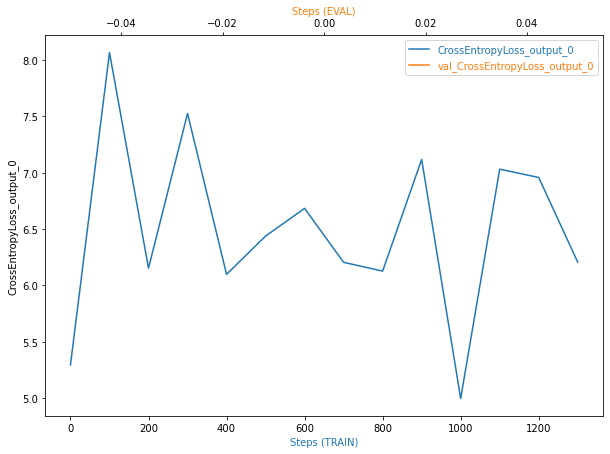

In [57]:
plot_tensor(trial, test_tensor)

**Considerations:**

&emsp; **TODO**:<br>

&emsp; **- Is there some anomalous behaviour in your debugging output? If so, what is the error and how can it be fixed?**

The debugging output has detected vanishing gradients, overfit, poor weight initialization, and loss not decreasing issues:

`
VanishingGradient: Error
Overfit: Error
Overtraining: NoIssuesFound
PoorWeightInitialization: Error
LossNotDecreasing: Error
LowGPUUtilization: NoIssuesFound
ProfilerReport: NoIssuesFound
`
To fix the problem one could consider improve hyperparameter tuning (tune other hyperparameters and larger ranges of hyperparameters values) and also changing model type.

&emsp; **- If there is not, then, let's suppose there was an error. What would that error look like and how could it be fixed?**

Erros are shown in the model.fit() logs, as above, and could be caused by a problem with model hyperparameter values or with the input data, a CPU and/or GPU utilizations and memory utilization issue, or output issues such as vanishing gradients and loss not decreasing. Ways to fix these errors are: tuning a bigger number (and larger ranges) of hyperparameters; improving input data; optimizing compute resources to solve CPU and GPU utilization and memory issues; consider changing model type or replacing activation function.

### 4.4. <a name="4.4">Display profiler data (timeline chart and profiler report)</a>
(<a href="#0">Go to top</a>)

**Support reading:**

1. Sagemaker Developer Guide: [Plot the System Metrics and Framework Metrics Data](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-access-data-profiling-default-plot.html)

In [40]:
### use TrainingJob object to fetch system metrics saved to s3
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

region=sagemaker.Session().boto_region_name

tj = TrainingJob(job_name, region)

# check if profile data is available
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-538248431797/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-538248431797/bestmodel-project3-2022-07-29-13-46-34-435/profiler-output


Profiler data from system is available


In [41]:
from smdebug.profiler.analysis.notebook_utils.heatmap import Heatmap

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()
framework_metrics_reader = tj.get_framework_metrics_reader()

view_heatmap = Heatmap(
    system_metrics_reader,
    framework_metrics_reader,
    select_dimensions=["CPU", "GPU", "I/O"],
    select_events=["total"],
    plot_height=450
)

[2022-07-29 14:23:34.737 ip-172-16-98-10.ec2.internal:8076 INFO metrics_reader_base.py:134] Getting 27 event files
select events:['total']
select dimensions:['CPU', 'GPU', 'I/O']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization', 'I/OWaitPercentage'}


In [42]:
# Fetch the path to profiler output

rule_output_path = best_estimator.output_path + best_estimator.latest_training_job.job_name + "/rule-output"

print(f"You will find the profiler report in\n {rule_output_path}")

You will find the profiler report in
 s3://sagemaker-us-east-1-538248431797/bestmodel-project3-2022-07-29-13-46-34-435/rule-output


In [43]:
# list s3 objects into the rule_output path
! aws s3 ls {rule_output_path} --recursive

2022-07-29 14:14:24     375488 bestmodel-project3-2022-07-29-13-46-34-435/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-07-29 14:14:23     223414 bestmodel-project3-2022-07-29-13-46-34-435/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-07-29 14:14:19        192 bestmodel-project3-2022-07-29-13-46-34-435/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-07-29 14:14:19        200 bestmodel-project3-2022-07-29-13-46-34-435/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-07-29 14:14:19       2024 bestmodel-project3-2022-07-29-13-46-34-435/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-07-29 14:14:19        127 bestmodel-project3-2022-07-29-13-46-34-435/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-07-29 14:14:19        199 bestmodel-project3-2022-07-29-13-46-34-435/rule-output/ProfilerReport/profiler-outp

In [44]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-538248431797/bestmodel-project3-2022-07-29-13-46-34-435/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-538248431797/bestmodel-project3-2022-07-29-13-46-34-435/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-538248431797/bestmodel-project3-2022-07-29-13-46-34-435/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-538248431797/bestmodel-project3-2022-07-29-13-46-34-435/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagem

In [45]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in best_estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
print(profiler_report_name)

In [46]:
# display the SageMaker Debugger profiling report

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## 5. <a name="5">Model Deployment</a>
(<a href="#0">Go to top</a>)

**Recommeded reading:**

1. Sagemaker Developer Guide: [Request Inferences from a Deployed Service](https://docs.aws.amazon.com/sagemaker/latest/dg/neo-requests-sdk.html)
2. Sagemaker Read the Docs: [End-to-End Multiclass Image Classification Example](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-fulltraining.html#Create-endpoint-configuration)
3. Use PyTorch with the SageMaker Python SDK. Deploy PyTorch Models. [The SageMaker PyTorch Model Server](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#id3)
4. AWS Blog: [Bring your own model with Amazon SageMaker script mode](https://aws.amazon.com/blogs/machine-learning/bring-your-own-model-with-amazon-sagemaker-script-mode/)
5. Sagemaker Developer Guide: [Deploy a Compiled Model Using SageMaker SDK](https://docs.aws.amazon.com/sagemaker/latest/dg/neo-deployment-hosting-services-sdk.html)
6. Sagemaker Read the Docs: [Predictors](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html#sagemaker.predictor.Predictor)

### 5.1. <a name="5.1">Create Model</a>
(<a href="#0">Go to top</a>)

In [9]:
epochs = '8'
test_batch_size = '209'
best_batch_size = '60'
best_lr = '0.0016232470062641088'

In [47]:
%%time

hyperparameters = {
    'epochs': epochs,
    'batch_size': best_batch_size,
    'test_batch_size': test_batch_size,
    'lr': best_lr
}

model = PyTorch(
    entry_point="hpo.py",
    base_job_name="model-project3", #prefix for training job name
    hyperparameters=hyperparameters,
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    framework_version="1.8.0",
    py_version="py36",
    disable_profiler = True
)

model.fit(inputs=model_inputs, logs='All')

2022-07-29 14:28:06 Starting - Starting the training job...
2022-07-29 14:28:22 Starting - Preparing the instances for training......
2022-07-29 14:29:29 Downloading - Downloading input data...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-07-29 14:31:17,539 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-29 14:31:17,541 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-29 14:31:17,550 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-07-29 14:31:17,557 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-07-29 14:31:17,988 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-29 14:31:18,000 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-29 14:31:18,011 sagemaker-tra


2022-07-29 14:31:15 Training - Training image download completed. Training in progress.Train Epoch: 1, Average Loss: 0.1479383310277156
Train Epoch: 2, Average Loss: 0.1120662460749798
Train Epoch: 3, Average Loss: 0.10939908688038762
Train Epoch: 4, Average Loss: 0.10461099620064605
Train Epoch: 5, Average Loss: 0.10069105978193424
Train Epoch: 6, Average Loss: 0.09724613031346492
Train Epoch: 7, Average Loss: 0.09416705549325499
Train Epoch: 8, Average Loss: 0.09143911951547398
Test set: Average loss: 0.02063915518482336
Test Accuracy 14.5933014354067%
Saving the model!!!
Model saved to /opt/ml/model/model.pth
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
#015  0%|          | 0.00/44.7M [00:00<?, ?B/s]#015 57%|█████▋    | 25.6M/44.7M [00:00<00:00, 268MB/s]#015100%|██████████| 44.7M/44.7M [00:00<00:00, 280MB/s]
2022-07-29 14:53:32,775 sagemaker-training-toolkit INFO     Reporting training SUCCESS



In [48]:
print(f"Training job name: {model.latest_training_job.name}")

Training job name: model-project3-2022-07-29-14-28-05-829


In [49]:
model_data_url = model.model_data
print(f"Model data location in s3: {model_data_url}")

Model data location in s3: s3://sagemaker-us-east-1-538248431797/model-project3-2022-07-29-14-28-05-829/output/model.tar.gz


In [ ]:
# -----------------------------------------------------------------------------------------

In [ ]:
## re-define latest_training_job and model_data_url variables, if needed

In [10]:
latest_training_job = "model-project3-2022-07-29-14-28-05-829"

In [11]:
model_data_url = "s3://sagemaker-us-east-1-538248431797/model-project3-2022-07-29-14-28-05-829/output/model.tar.gz"

In [ ]:
# -----------------------------------------------------------------------------------------

In [27]:
# call the sagemaker.pytorch.model.PyTorchModel constructor to create a model object

from sagemaker.pytorch.model import PyTorchModel

my_model = PyTorchModel(
    model_data = model_data_url,
    role = get_execution_role(),
    entry_point = 'inference.py',
    framework_version="1.8.0",
    py_version = 'py36'
)


### 5.2. <a name="5.2">Create Endpoint</a>
(<a href="#0">Go to top</a>)

In [28]:
%%time
# deploy model to an endpoint

from sagemaker.serializers import IdentitySerializer

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
#json_deserializer = sagemaker.deserializers.JSONDeserializer()

predictor = my_model.deploy(
    initial_instance_count = 1,
    instance_type = "ml.m5.xlarge", #"ml.p2.xlarge" #
    serializer = jpeg_serializer,
    #deserializer = json_deserializer
)

-----!CPU times: user 3.08 s, sys: 314 ms, total: 3.39 s
Wall time: 2min 35s


In [29]:
# grab endpoint name
print(f"Endpoint name: {predictor.endpoint_name}")

Endpoint name: pytorch-inference-2022-07-29-18-15-03-318


In [30]:
# print the status of the endpoint
client = boto3.client('sagemaker')
endpoint_response = client.describe_endpoint(EndpointName=predictor.endpoint_name)
status = endpoint_response["EndpointStatus"]
print("Endpoint creation ended with EndpointStatus = {}".format(status))

if status != "InService":
    raise Exception("Endpoint creation failed.")

Endpoint creation ended with EndpointStatus = InService


### 5.3. <a name="5.3">Perform Inference</a>
(<a href="#0">Go to top</a>)

#### 5.3.1. <a name="5.3.1">Grab validation data</a>

In [16]:
# create a list of classes sorted by indexes
image_categories = []
for i in sorted(dict_cls.keys()):
    image_categories.append(dict_cls[i])

In [55]:
image_categories

['Affenpinscher',
 'Afghan_hound',
 'Airedale_terrier',
 'Akita',
 'Alaskan_malamute',
 'American_eskimo_dog',
 'American_foxhound',
 'American_staffordshire_terrier',
 'American_water_spaniel',
 'Anatolian_shepherd_dog',
 'Australian_cattle_dog',
 'Australian_shepherd',
 'Australian_terrier',
 'Basenji',
 'Basset_hound',
 'Beagle',
 'Bearded_collie',
 'Beauceron',
 'Bedlington_terrier',
 'Belgian_malinois',
 'Belgian_sheepdog',
 'Belgian_tervuren',
 'Bernese_mountain_dog',
 'Bichon_frise',
 'Black_and_tan_coonhound',
 'Black_russian_terrier',
 'Bloodhound',
 'Bluetick_coonhound',
 'Border_collie',
 'Border_terrier',
 'Borzoi',
 'Boston_terrier',
 'Bouvier_des_flandres',
 'Boxer',
 'Boykin_spaniel',
 'Briard',
 'Brittany',
 'Brussels_griffon',
 'Bull_terrier',
 'Bulldog',
 'Bullmastiff',
 'Cairn_terrier',
 'Canaan_dog',
 'Cane_corso',
 'Cardigan_welsh_corgi',
 'Cavalier_king_charles_spaniel',
 'Chesapeake_bay_retriever',
 'Chihuahua',
 'Chinese_crested',
 'Chinese_shar-pei',
 'Chow_cho

In [31]:
# random select from the dictionary of classes created at the begining of the notebook
image_class = random.choice(dir_list)
print(f"Class: {image_class}")

class_path = f"./dogImages/valid/{image_class}"
print(f"Path to files in this class: {class_path}")

# select random image from selected class
image = random.choice(os.listdir(class_path))
print(f"Selected image: {image}")

local_image_path = f"{class_path}/{image}"
print(f"Local path to selected image: {local_image_path}")


Class: 110.Norwegian_lundehund
Path to files in this class: ./dogImages/valid/110.Norwegian_lundehund
Selected image: Norwegian_lundehund_07194.jpg
Local path to selected image: ./dogImages/valid/110.Norwegian_lundehund/Norwegian_lundehund_07194.jpg


In [57]:
type(local_image_path)

str

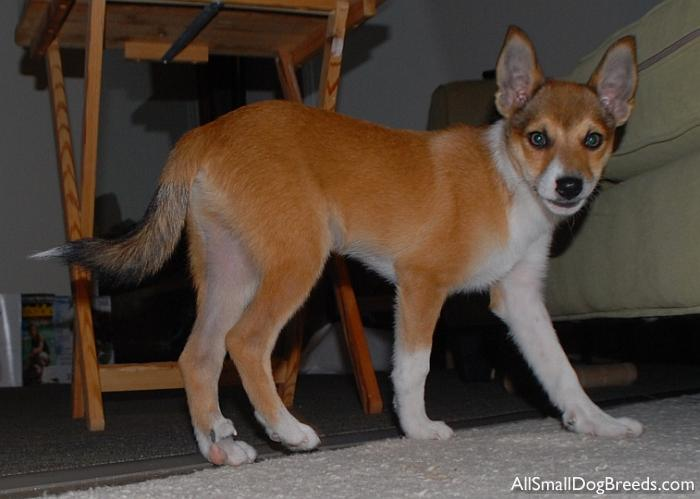

In [32]:
## Image.open() takes a file path as argument and returns a PIL.Image object
img = Image.open(local_image_path)
img.show()

#### 5.3.2. <a name="5.3.2">Test endpoint</a>

##### 5.3.2.1. <a name="5.3.2.1">Invoke Endpoint with SageMaker SDK</a>

In [74]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [33]:
with open(local_image_path, 'rb') as f:
    payload = f.read()
    
type(payload)

bytes

In [34]:
result = predictor.predict(
    data = payload,
    initial_args = {'ContentType':"image/jpeg"}, #arguments for boto3 invoke_endpoint call
)

In [36]:
print(result)

[[-13.817846  -14.305858  -14.783888  -13.138739  -13.87062   -15.527047
  -15.307027  -13.893936  -17.464893  -16.29027   -13.471047  -14.766122
  -21.488838  -11.168025  -16.191774  -13.787786  -14.630179  -13.951846
  -19.134712  -13.2775755 -15.6131315 -12.941747  -16.877268  -17.550003
  -16.123446  -15.695658  -13.487649  -16.246548  -14.848456  -15.041796
  -15.816683  -13.798311  -20.330847  -12.72513   -16.920153  -16.07171
  -13.4627495 -16.67042   -12.646129  -17.540604  -14.030537  -20.15607
  -10.403902  -19.942108  -10.854033  -17.286818  -16.78787   -12.223215
  -14.760687  -14.556213  -13.802609  -14.229674  -17.219889  -12.804436
  -18.652514  -13.945686  -14.526746  -19.245684  -13.492569  -14.586446
  -14.561611  -13.919     -13.979121  -16.222614  -13.19205   -18.960516
   -9.680528  -19.776329  -14.5988655 -14.195471  -12.910676  -14.547511
  -14.595775  -15.931622  -14.78298   -13.347364  -15.309886  -14.442026
  -15.762883  -14.685376  -12.45737   -17.538996  -11

In [63]:
print(len(result[0]))

133


In [35]:
inference = np.argmax(result)
inference

117

##### 5.3.2.2. <a name="5.3.2.2">Invoke with boto3 and SageMaker runtime (Serveless inference)</a>

In [79]:
# run a prediction on the endpoint using Boto3
runtime = boto3.Session().client(service_name="runtime.sagemaker")

In [80]:
inference_response = runtime.invoke_endpoint(
    EndpointName = predictor.endpoint_name,
    ContentType="image/jpeg", #application/x-image",
    Body=payload
)

In [81]:
inference_response

{'ResponseMetadata': {'RequestId': '0120aa66-a5d0-4b2c-b6df-63c9ec7c0576',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '0120aa66-a5d0-4b2c-b6df-63c9ec7c0576',
   'x-amzn-invoked-production-variant': 'AllTraffic',
   'date': 'Fri, 29 Jul 2022 15:05:20 GMT',
   'content-type': 'application/json',
   'content-length': '2737'},
  'RetryAttempts': 0},
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'AllTraffic',
 'Body': <botocore.response.StreamingBody at 0x7f9c4cb83160>}

In [82]:
# result will be in json format
#result = inference_response["Body"].read()
result = inference_response['Body'].read().decode('utf-8')

result

'[[-13.517264366149902, -15.009502410888672, -12.291629791259766, -14.696197509765625, -13.609783172607422, -14.757593154907227, -15.6300687789917, -13.527203559875488, -13.03052806854248, -16.788806915283203, -13.711688041687012, -14.7457275390625, -14.749755859375, -16.07546043395996, -13.90304183959961, -13.65733528137207, -13.008020401000977, -14.806560516357422, -13.562629699707031, -16.835161209106445, -13.608194351196289, -19.779857635498047, -13.552001953125, -16.12543487548828, -23.738510131835938, -10.632965087890625, -14.459249496459961, -15.595778465270996, -14.660918235778809, -12.39436149597168, -15.686576843261719, -20.45336151123047, -10.130941390991211, -22.30048370361328, -18.019821166992188, -10.816575050354004, -25.606029510498047, -11.855751991271973, -16.698707580566406, -14.8770170211792, -14.955772399902344, -12.198347091674805, -21.815689086914062, -12.306177139282227, -18.401123046875, -14.903800964355469, -14.39933967590332, -17.07168197631836, -12.9924678802

In [83]:
# convert result to ndarray
result = json.loads(result)

result

[[-13.517264366149902,
  -15.009502410888672,
  -12.291629791259766,
  -14.696197509765625,
  -13.609783172607422,
  -14.757593154907227,
  -15.6300687789917,
  -13.527203559875488,
  -13.03052806854248,
  -16.788806915283203,
  -13.711688041687012,
  -14.7457275390625,
  -14.749755859375,
  -16.07546043395996,
  -13.90304183959961,
  -13.65733528137207,
  -13.008020401000977,
  -14.806560516357422,
  -13.562629699707031,
  -16.835161209106445,
  -13.608194351196289,
  -19.779857635498047,
  -13.552001953125,
  -16.12543487548828,
  -23.738510131835938,
  -10.632965087890625,
  -14.459249496459961,
  -15.595778465270996,
  -14.660918235778809,
  -12.39436149597168,
  -15.686576843261719,
  -20.45336151123047,
  -10.130941390991211,
  -22.30048370361328,
  -18.019821166992188,
  -10.816575050354004,
  -25.606029510498047,
  -11.855751991271973,
  -16.698707580566406,
  -14.8770170211792,
  -14.955772399902344,
  -12.198347091674805,
  -21.815689086914062,
  -12.306177139282227,
  -18.40

In [117]:
len(result[0])

133

In [84]:
inference = np.argmax(result)
inference

124

#### 5.3.3. <a name="5.3.3">PRINT PREDICTION(S)</a>

In [37]:
# the result will output the probabilities for all classes
# find the class with maximum probability
index = np.argmax(result)

# print the most probable class and its probability
print(f"Result: predicted label(s) - {image_categories[index]}")

Result: predicted label(s) - Pembroke_welsh_corgi


In [38]:
dict_cls[index]

'Pembroke_welsh_corgi'

In [39]:
## Grab image label

print(image)
groundtruth = image.split('_0')[0]
print(groundtruth)

Norwegian_lundehund_07194.jpg
Norwegian_lundehund


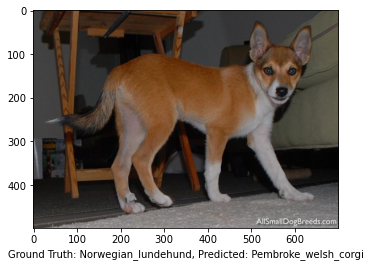

In [40]:
## plot image with the groud truth and the predicted label

from matplotlib import pyplot as plt

plt.imshow(plt.imread(local_image_path))
plt.xlabel(f"Ground Truth: {groundtruth}, Predicted: {image_categories[index]}")
plt.show()

In [ ]:
## print(f"Probability: {result[0][index]}")

### 5.4. <a name="5.4">Clean up</a>
(<a href="#0">Go to top</a>)

*Delete model and endpoint:*

**Reading:**

1. Get Started with Amazon SageMaker Notebook Instances: [Clean Up -- AWS documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html)

In [41]:
# shutdown/delete the endpoint once the work is done

print(f"deleting endpoint: {predictor.endpoint_name}")
client.delete_endpoint(EndpointName = predictor.endpoint_name)

deleting endpoint: pytorch-inference-2022-07-29-18-15-03-318


{'ResponseMetadata': {'RequestId': 'c8e08083-bcc2-4a93-958e-77c6e369e487',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c8e08083-bcc2-4a93-958e-77c6e369e487',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 29 Jul 2022 18:24:44 GMT'},
  'RetryAttempts': 0}}

In [42]:
print(f"deleting Model: {my_model.name}")
client.delete_model(ModelName = my_model.name)

deleting Model: pytorch-inference-2022-07-29-18-15-02-689


{'ResponseMetadata': {'RequestId': '89b9251d-3503-438f-9b0e-2d0e914dbcb9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '89b9251d-3503-438f-9b0e-2d0e914dbcb9',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 29 Jul 2022 18:24:46 GMT'},
  'RetryAttempts': 0}}